<a href="https://colab.research.google.com/github/taekjunkim/artiphysiology2020/blob/main/get_vgg16_center_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

stim_path ='/content/gdrive/My Drive/UW_PasupathyLab/ShortTermWork/Artiphysiology2020/Animal_Icons/stims/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.get_device_name(0)  
else:
    device = torch.device("cpu")

import torchvision.models as models
import torch.nn as nn

import numpy as np;

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
# Comment 0: define transformation that you wish to apply on image
data_transforms = transforms.Compose(
    #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    #to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
    #if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
    # or if the numpy.ndarray has dtype = np.uint8
    [transforms.ToTensor(),
     #normalization of pre-trained networks:
     #from docs:
     #All pre-trained models expect input images normalized in the same way, 
     #i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where
     #H and W are expected to be at least 224. The images have to be loaded 
     #in to a range of [0, 1] and then normalized using 
     #mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
     transforms.Normalize([0.485, 0.456, 0.406], 
                          [0.229, 0.224, 0.225])])#

# Comment 1 : Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(root= stim_path, transform=data_transforms)
# Comment 2: Using the image datasets and the transforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False, num_workers=2);

In [ ]:
""" modification of Imagefolder to get image path
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
dataset = ImageFolderWithPaths(root=data_dir, transform=test_transformer)    
"""    
print(image_datasets.imgs[20])

('/content/gdrive/My Drive/UW_PasupathyLab/ShortTermWork/Artiphysiology2020/Animal_Icons/stims/class00/stim0020.png', 0)


In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval();
vgg16.to(device)

layers_of_interest = [17,19,21,24,26,28]; # layers where RF size > 50 pix

outputs = []; #simple function to store outputs
def store_output(module,input,output):
    cPos = int(np.ceil(np.shape(output)[2]/2)-1);
    outputs.append(output[:,:,cPos,cPos]);

for i,layer in enumerate(vgg16.features):
    if i in layers_of_interest:
        print(layer)
        layer.register_forward_hook(store_output);
    if isinstance(layer, nn.ReLU):
        layer.inplace = False #set inplace rectification to False to get unrect responses        



Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
vgg16_outputs = [];
for i, (images,labels) in enumerate(dataloaders):

    if torch.cuda.is_available():  
        images = images.cuda();
    #images = Variable(images.float());
    #Test input
    outputs = [];
    out = vgg16(images)

    print('batch(size 10)# '+str(i)+' was processed')

    if torch.cuda.is_available():  
        for j in range(len(outputs)):
            outputs[j] = outputs[j].cpu();
    if i==0:
        vgg16_outputs = outputs;
        for j in range(len(outputs)):
            vgg16_outputs[j] = vgg16_outputs[j].detach().numpy();
    else:
        for j in range(len(outputs)):
            vgg16_outputs[j] = np.append(vgg16_outputs[j],outputs[j].detach().numpy(),axis=0);


batch(size 10)# 0 was processed
batch(size 10)# 1 was processed
batch(size 10)# 2 was processed
batch(size 10)# 3 was processed
batch(size 10)# 4 was processed
batch(size 10)# 5 was processed
batch(size 10)# 6 was processed
batch(size 10)# 7 was processed
batch(size 10)# 8 was processed
batch(size 10)# 9 was processed
batch(size 10)# 10 was processed
batch(size 10)# 11 was processed
batch(size 10)# 12 was processed
batch(size 10)# 13 was processed
batch(size 10)# 14 was processed
batch(size 10)# 15 was processed
batch(size 10)# 16 was processed
batch(size 10)# 17 was processed
batch(size 10)# 18 was processed
batch(size 10)# 19 was processed
batch(size 10)# 20 was processed
batch(size 10)# 21 was processed
batch(size 10)# 22 was processed
batch(size 10)# 23 was processed
batch(size 10)# 24 was processed
batch(size 10)# 25 was processed
batch(size 10)# 26 was processed
batch(size 10)# 27 was processed
batch(size 10)# 28 was processed
batch(size 10)# 29 was processed
batch(size 10)# 30 w

In [ ]:
len(vgg16_outputs)

6

In [ ]:
import os;
os.chdir(stim_path)
np.savez('vgg16_outputs.npz',conv8=vgg16_outputs[0],
                             conv9=vgg16_outputs[1],
                             conv10=vgg16_outputs[2],
                             conv11=vgg16_outputs[3],
                             conv12=vgg16_outputs[4],
                             conv13=vgg16_outputs[5]);

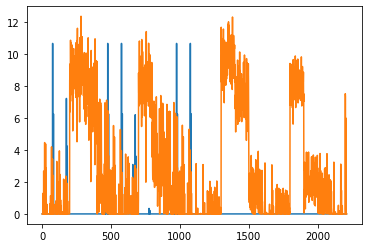

In [ ]:
data = np.load('vgg16_outputs.npz');

import matplotlib.pyplot as plt;
plt.plot(data['conv8'][:,1].clip(min=0))
plt.plot(data['conv13'][:,11].clip(min=0))

In [ ]:
np.mean(data['conv13'])

0.13483968